# Agentic Predictive Maintenance for Insured Assets
---
**Objective:** Develop an agentic predictive maintenance solution using time-series sensor data.

**Core Components:**
* **Data:** Time-series sensor data, policy data, and maintenance logs/manuals.
* **Model:** Time-aware model selection (forecasting/classification) and hyperparameter tuning.
* **Agent:** An AI agent combining deterministic checks, RAG (retrieval from manuals), and LLM reasoning to provide explainable maintenance recommendations.

## 1. Data Exploration & Preprocessing
### Complete Data Pipeline (Load, Clean, Normalize, & Save)

This cell contains the **complete, self-contained, and corrected Python script** for the entire data pipeline. It consolidates all functions from data ingestion, cleaning, and normalization into a single, runnable block.

**Load -> Clean -> Normalize -> Save**

### Key Actions Performed:
1.  **Load & Label:** Reads the raw `.txt` files (`train`, `test`, `RUL`) and computes the `RUL` (Remaining Useful Life) target for every row in both sets.
2.  **Clean:** Applies a series of deep-cleaning functions to the raw, labeled data:
    * `align_cycles`: Fills in any missing cycle timestamps with `NaN` rows to create a complete time index.
    * `impute_missing`: Uses linear interpolation and ffill/bfill to fill all `NaN` values for sensors and operational settings.
    * `cap_outliers`: Uses a rolling Z-score (`z_thresh=4`) to identify and "cap" extreme sensor spikes or noise.
3.  **Normalize:** Applies the appropriate `StandardScaler` (global for FD001/FD003, conditional/clustered for FD002/FD004) *only after* the data has been cleaned.
4.  **Save Artifacts:**
    * Saves the final, processed (cleaned and normalized) data as `.csv` files (e.g., `train_FD001_normalized.csv`) to `data/processed/`.
    * Saves the fitted `StandardScaler` objects as `.pkl` files to `artifacts/scalers/` for later use during inference.
5.  **Visualize:** Plots "before vs. after" graphs to show the effect of the outlier capping and a correlation heatmap of the *cleaned* data.


In [1]:
"""
==================================================================
Data Ingestion, Cleaning, Normalization, and Saving
==================================================================

Purpose:
- Load CMAPSS FD001-FD004
- Compute RUL
- **CLEAN:** Align cycles, impute missing data, and cap outliers
- **NORMALIZE:** Apply standardization (global or conditional) to the *cleaned* data
- Save final processed CSVs and scalers
- Plot EDA (including raw vs. clean comparisons)

Dependencies: pandas, numpy, scikit-learn, matplotlib, seaborn, joblib
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ------------------------
# 1. CONFIGURATION
# ------------------------
OP_COLS = ["op_setting_1", "op_setting_2", "op_setting_3"]
SENSOR_COLS = [f"sensor_{i}" for i in range(1, 22)]
COL_NAMES = ["unit", "cycle"] + OP_COLS + SENSOR_COLS

NORMALIZATION_MAP = {
    "FD001": "global",
    "FD002": "conditional",
    "FD003": "global",
    "FD004": "conditional",
}


Starting FULL Data Pipeline (Load, Clean, Normalize)
Project Root: C:\myProjects\Agentic-Predictive-Maintenance\notebooks
Loading Raw Data From: C:\myProjects\Agentic-Predictive-Maintenance\data\raw\CMAPSS
Saving Processed Data To: C:\myProjects\Agentic-Predictive-Maintenance\data\processed\CMAPSS
Saving Scalers To: C:\myProjects\Agentic-Predictive-Maintenance\artifacts\scalers
--- Starting processing for FD001 ---
[1/5] Loading raw data and computing RUL for FD001...
Train shape (raw): (20631, 27), Test shape (raw): (13096, 27)

[2/5] Applying cleaning pipeline (align, impute, cap outliers)...
Cleaning complete. Train shape (clean): (20631, 27)

[3/5] Applying normalization on CLEANED data...
Saved global scaler to ..\artifacts\scalers\FD001_global_scaler.pkl
Normalization complete.

[4/5] Saving processed & normalized files...
Saved processed files: ..\data\processed\CMAPSS\FD001\train_FD001_normalized.csv, ..\data\processed\CMAPSS\FD001\test_FD001_normalized.csv

[5/5] Plotting EDA 

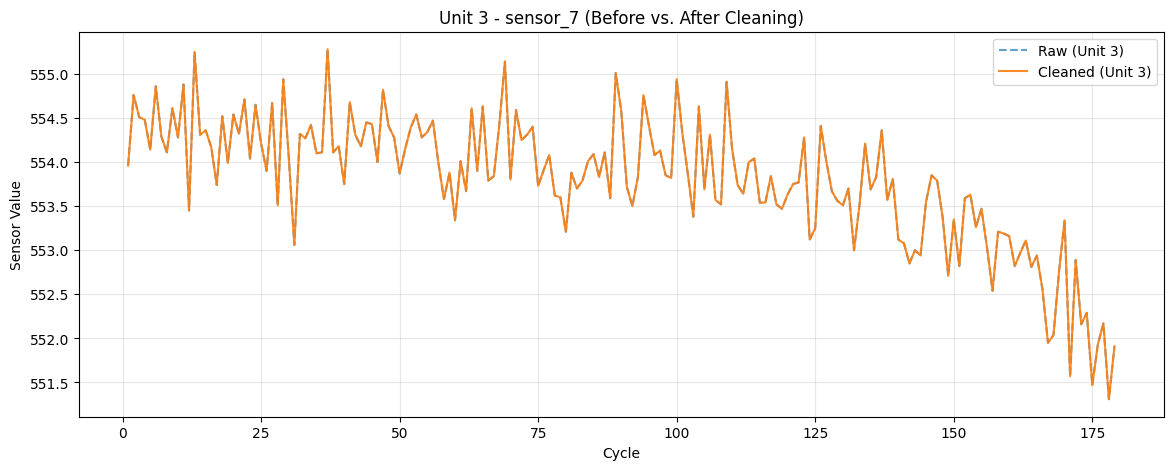

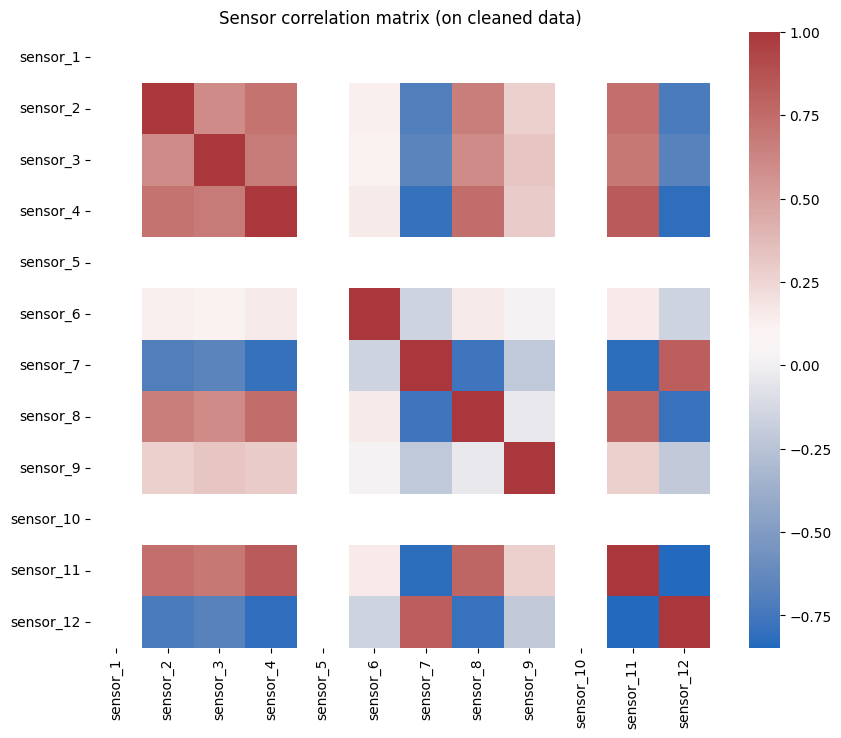

Done plotting.
✅ Successfully processed FD001
--- Starting processing for FD002 ---
[1/5] Loading raw data and computing RUL for FD002...
Train shape (raw): (53759, 27), Test shape (raw): (33991, 27)

[2/5] Applying cleaning pipeline (align, impute, cap outliers)...
Cleaning complete. Train shape (clean): (53759, 27)

[3/5] Applying normalization on CLEANED data...
Saved 7 cluster scalers and unit->cluster map for FD002
Normalization complete.

[4/5] Saving processed & normalized files...
Saved processed files: ..\data\processed\CMAPSS\FD002\train_FD002_normalized.csv, ..\data\processed\CMAPSS\FD002\test_FD002_normalized.csv

[5/5] Plotting EDA graphs for FD002...
Sensor summary stats (clean):
                 mean         std      min      max
sensor_1   472.910207   26.389707   445.00   518.67
sensor_2   579.672399   37.289399   535.53   644.52
sensor_3  1419.971013  105.946341  1243.73  1612.88
sensor_4  1205.442024  119.123428  1023.77  1439.23
sensor_5     8.031986    3.613839    

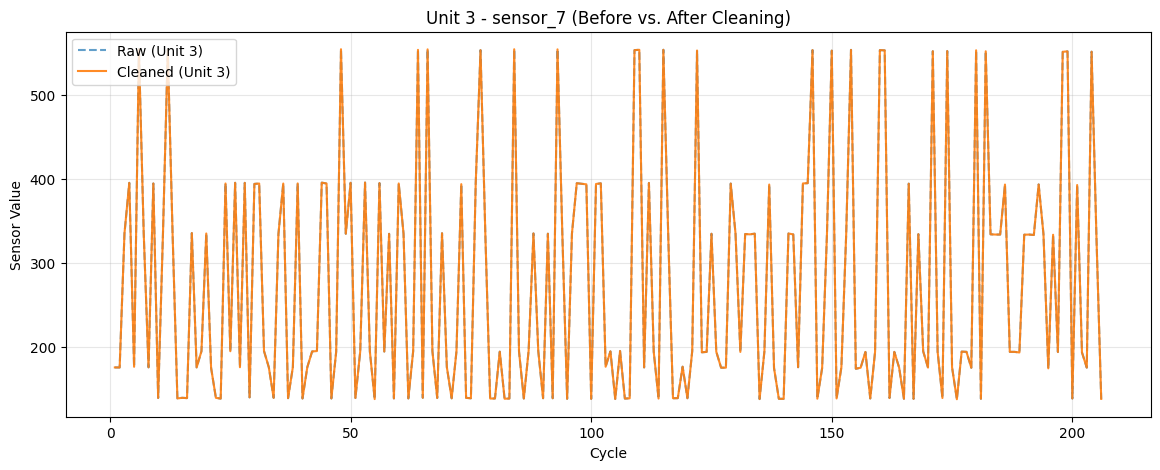

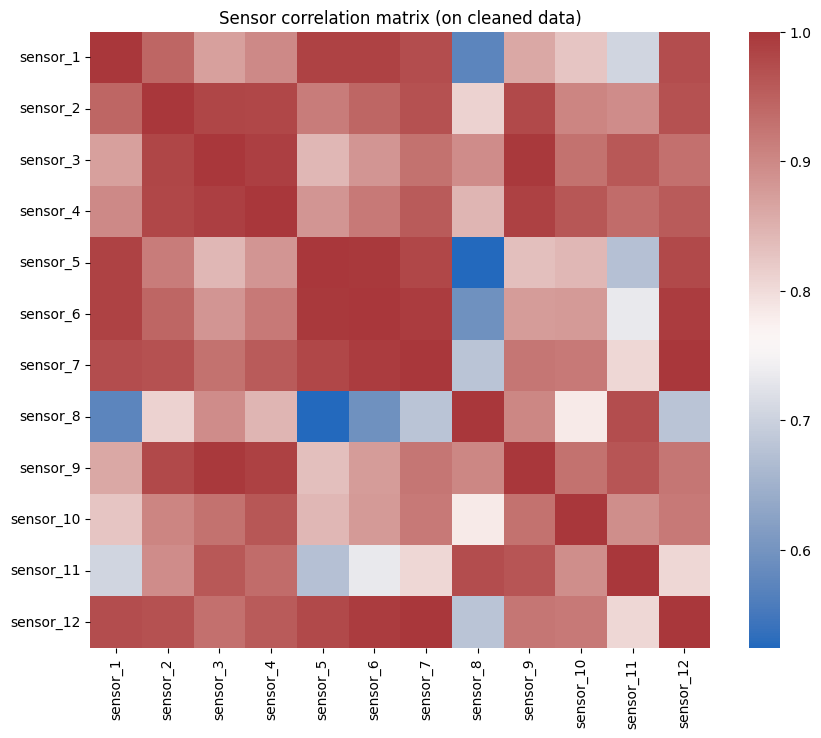

Done plotting.
✅ Successfully processed FD002
--- Starting processing for FD003 ---
[1/5] Loading raw data and computing RUL for FD003...
Train shape (raw): (24720, 27), Test shape (raw): (16596, 27)

[2/5] Applying cleaning pipeline (align, impute, cap outliers)...
Cleaning complete. Train shape (clean): (24720, 27)

[3/5] Applying normalization on CLEANED data...
Saved global scaler to ..\artifacts\scalers\FD003_global_scaler.pkl
Normalization complete.

[4/5] Saving processed & normalized files...
Saved processed files: ..\data\processed\CMAPSS\FD003\train_FD003_normalized.csv, ..\data\processed\CMAPSS\FD003\test_FD003_normalized.csv

[5/5] Plotting EDA graphs for FD003...
Sensor summary stats (clean):
                 mean           std      min      max
sensor_1   518.670000  0.000000e+00   518.67   518.67
sensor_2   642.457858  5.230311e-01   640.84   645.11
sensor_3  1588.079175  6.810418e+00  1564.30  1615.39
sensor_4  1404.471212  9.773178e+00  1377.06  1441.16
sensor_5    14.

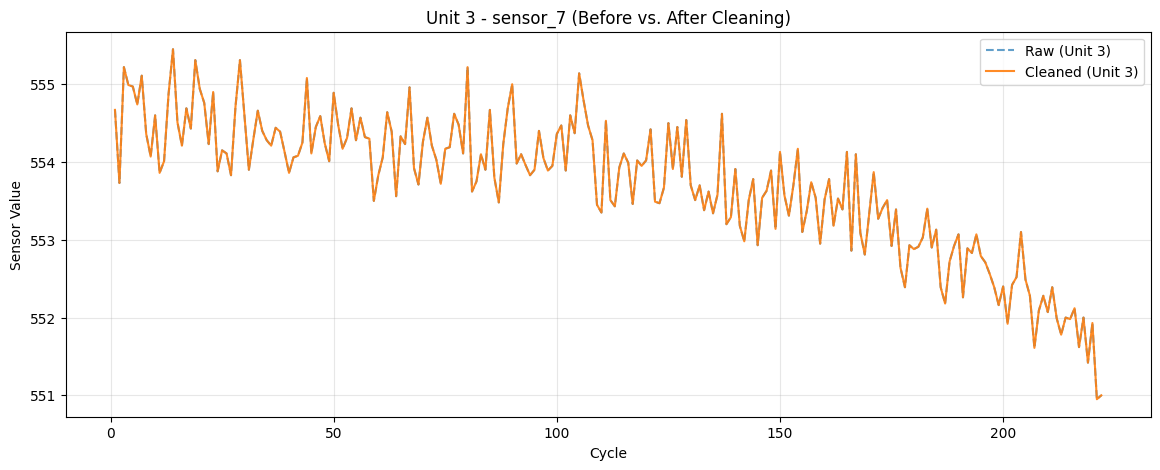

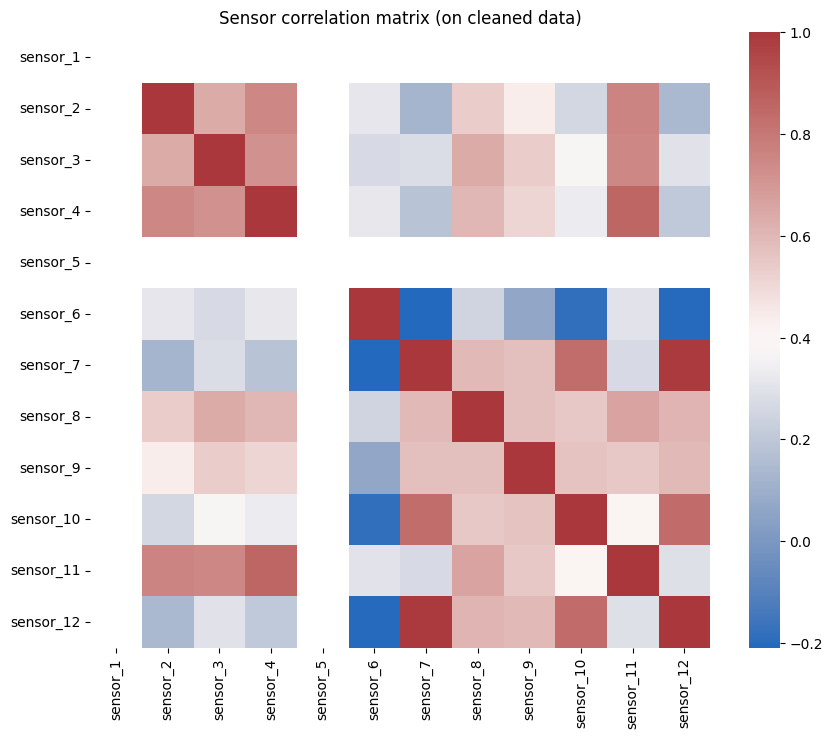

Done plotting.
✅ Successfully processed FD003
--- Starting processing for FD004 ---
[1/5] Loading raw data and computing RUL for FD004...
Train shape (raw): (61249, 27), Test shape (raw): (41214, 27)

[2/5] Applying cleaning pipeline (align, impute, cap outliers)...
Cleaning complete. Train shape (clean): (61249, 27)

[3/5] Applying normalization on CLEANED data...
Saved 7 cluster scalers and unit->cluster map for FD004
Normalization complete.

[4/5] Saving processed & normalized files...
Saved processed files: ..\data\processed\CMAPSS\FD004\train_FD004_normalized.csv, ..\data\processed\CMAPSS\FD004\test_FD004_normalized.csv

[5/5] Plotting EDA graphs for FD004...
Sensor summary stats (clean):
                 mean         std      min      max
sensor_1   472.882435   26.436832   445.00   518.67
sensor_2   579.420056   37.342647   535.48   644.42
sensor_3  1417.896600  106.167598  1242.67  1613.00
sensor_4  1201.915359  119.327591  1024.42  1440.77
sensor_5     8.031626    3.622872    

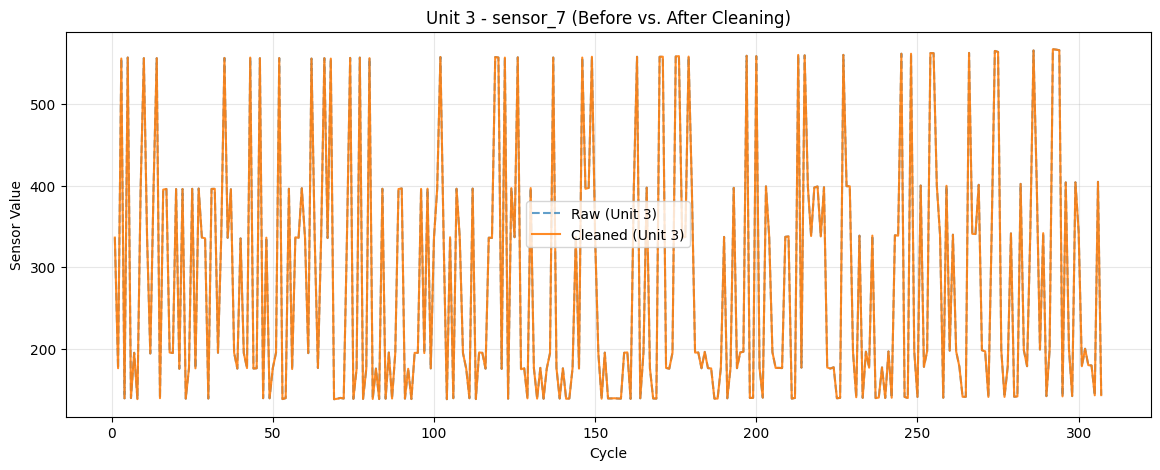

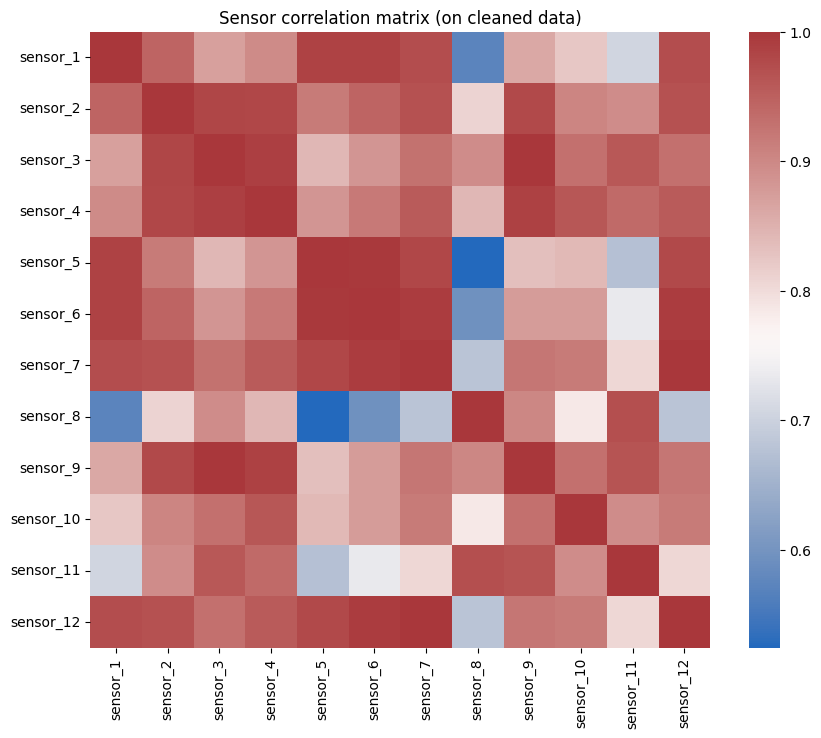

Done plotting.
✅ Successfully processed FD004

--- All processing finished! ---

Sample Final *Normalized* Data FD001 (Train):
   cycle  unit  op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
0      1     1     -0.315980     -1.372953           0.0       0.0 -1.721725   
1      2     1      0.872722     -1.031720           0.0       0.0 -1.061780   
2      3     1     -1.961874      1.015677           0.0       0.0 -0.661813   
3      4     1      0.324090     -0.008022           0.0       0.0 -0.661813   
4      5     1     -0.864611     -0.690488           0.0       0.0 -0.621816   

   sensor_3  sensor_4      sensor_5  ...  sensor_13  sensor_14  sensor_15  \
0 -0.134255 -0.925936 -5.329071e-15  ...  -1.059424  -0.269071  -0.603816   
1  0.211528 -0.643726 -5.329071e-15  ...  -0.363751  -0.642845  -0.275852   
2 -0.413166 -0.525953 -5.329071e-15  ...  -0.920290  -0.551629  -0.649144   
3 -1.261314 -0.784831 -5.329071e-15  ...  -0.224616  -0.520176  -1.971665   
4 -1.25

In [2]:
# ------------------------
# 2. DATA LOADING & RUL FUNCTIONS
# ------------------------

def read_cmapps_file(filepath: Path) -> pd.DataFrame:
    """Read a CMAPSS train or test txt file into DataFrame with proper column names."""
    df = pd.read_csv(filepath, sep="\s+", header=None, names=COL_NAMES)
    df["unit"] = df["unit"].astype(int)
    df["cycle"] = df["cycle"].astype(int)
    return df

def read_rul_file(filepath: Path) -> pd.Series:
    """Read RUL file (single column) and return a Series indexed by unit (1-based)."""
    # [FIX] 'squeeze=True' is deprecated. Replaced with .read_csv(...).squeeze("columns")
    rul = pd.read_csv(filepath, header=None).squeeze("columns")
    rul.index = np.arange(1, len(rul) + 1)  # unit ids are 1..N
    rul.name = "RUL"
    return rul

def compute_train_rul(df_train: pd.DataFrame) -> pd.DataFrame:
    """Add RUL column to train DataFrame: RUL = max_cycle_for_unit - cycle"""
    max_cycle = df_train.groupby("unit")["cycle"].transform("max")
    df = df_train.copy()
    df["RUL"] = max_cycle - df["cycle"]
    return df

def compute_test_rul(df_test: pd.DataFrame, rul_series: pd.Series) -> pd.DataFrame:
    """Compute per-row RUL for test set by merging per-unit RUL."""
    df = df_test.copy()
    final_cycles = df.groupby("unit")["cycle"].transform("max")
    df = df.merge(rul_series.rename("RUL_unit"), left_on="unit", right_index=True)
    df["RUL"] = df["RUL_unit"] + (final_cycles - df["cycle"])
    df.drop(columns=["RUL_unit"], inplace=True)
    return df

# ------------------------
# 3. DATA CLEANING FUNCTIONS (Align, Impute, Cap)
# ------------------------
def align_cycles(df):
    """
    Ensures a full timeline for each unit.
    Merges the data onto a complete cycle range (min to max), 
    creating NaN rows for any missing cycles.
    """
    out = []
    for unit, grp in df.groupby("unit"):
        full_cycles = pd.DataFrame({"cycle": range(grp.cycle.min(), grp.cycle.max()+1)})
        full_cycles["unit"] = unit
        merged = full_cycles.merge(grp, on=["unit","cycle"], how="left")
        out.append(merged)
    return pd.concat(out).reset_index(drop=True)

def impute_missing(df):
    """
    Impute missing sensor data (using interpolate) and op_settings (using ffill).
    Fixed: use groupby(...).transform(...) to ensure the returned Series aligns with df.index
    """
    df = df.copy()
    
    # 1. Interpolate sensors (handles gaps)
    for col in SENSOR_COLS:
        # transform returns a Series aligned with original df.index -> avoids index-mismatch errors
        df[col] = df.groupby("unit")[col].transform(
            lambda x: x.interpolate(method='linear', limit_direction='both', limit=2).ffill().bfill()
        )

    # 2. Forward/Backward fill op_settings and RUL (per unit)
    fill_cols = OP_COLS + ["RUL"]
    for col in fill_cols:
        if col in df.columns:
            df[col] = df.groupby("unit")[col].transform(lambda x: x.ffill().bfill())

    # Optional: if entire row's sensors are NaN, drop those rows
    # (keep this behavior if you want to remove completely-empty rows/units)
    df = df.dropna(subset=SENSOR_COLS, how='all')

    return df

def cap_outliers(df, window=30, z_thresh=4):
    """
    Caps sensor outliers using a rolling Z-score.
    """
    df = df.copy()
    for sensor in SENSOR_COLS:
        rolling_mean = df.groupby("unit")[sensor].rolling(window, min_periods=1).mean().reset_index(level=0,drop=True)
        rolling_std  = df.groupby("unit")[sensor].rolling(window, min_periods=1).std().reset_index(level=0,drop=True)
        rolling_std = rolling_std.fillna(0) + 1e-6
        
        z = (df[sensor] - rolling_mean) / rolling_std
        
        upper = rolling_mean + z_thresh * rolling_std
        lower = rolling_mean - z_thresh * rolling_std
        
        df[sensor] = np.where(df[sensor] > upper, upper, df[sensor])
        df[sensor] = np.where(df[sensor] < lower, lower, df[sensor])
    return df

# ------------------------
# 4. NORMALIZATION FUNCTIONS
# ------------------------

def global_standardize(train_df: pd.DataFrame, test_df: pd.DataFrame, scaler_dir: Path, cols: list = None, subset_name: str = "FD"):
    """Fit StandardScaler on train_df[cols] (global) and transform both train and test."""
    if cols is None:
        cols = SENSOR_COLS + OP_COLS
    scaler = StandardScaler()
    
    # **IMPORTANT**: Fit scaler ONLY on the training data
    X_train = train_df[cols].values
    scaler.fit(X_train)
    
    # Transform both train and test
    X_test = test_df[cols].values
    
    train_t = train_df.copy()
    test_t = test_df.copy()
    train_t[cols] = scaler.transform(X_train)
    test_t[cols] = scaler.transform(X_test)
    
    scaler_path = scaler_dir / f"{subset_name}_global_scaler.pkl"
    joblib.dump(scaler, scaler_path)
    print(f"Saved global scaler to {scaler_path}")
    return train_t, test_t, scaler


def conditional_standardize(train_df: pd.DataFrame, test_df: pd.DataFrame, scaler_dir: Path, n_clusters: int = 6, subset_name: str = "FD"):
    """Cluster units by operating settings and standardize sensor+op features per-cluster."""
    
    unit_means = train_df.groupby("unit")[OP_COLS].mean().reset_index()
    X = unit_means[OP_COLS].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    unit_means["cluster"] = labels

    unit_cluster = dict(zip(unit_means["unit"], unit_means["cluster"]))
    
    train_t = train_df.copy()
    test_t = test_df.copy()
    scalers = {}

    train_t["cluster"] = train_t["unit"].map(unit_cluster)
    test_t["cluster"] = test_t["unit"].map(unit_cluster)
    test_t["cluster"] = test_t["cluster"].fillna(-1) # Handle test units not in train

    cols = SENSOR_COLS + OP_COLS
    
    fallback_scaler = StandardScaler().fit(train_df[cols].values)
    scalers[-1] = fallback_scaler # Fallback for cluster -1

    for c in sorted(train_t["cluster"].unique()):
        mask_train = train_t["cluster"] == c
        Xc_train = train_t.loc[mask_train, cols]
        
        if Xc_train.shape[0] < 2:
            scaler = fallback_scaler
        else:
            scaler = StandardScaler()
            scaler.fit(Xc_train.values)
            
        scalers[c] = scaler
        joblib.dump(scaler, scaler_dir / f"{subset_name}_cluster_{c}_scaler.pkl")

    all_clusters = np.union1d(train_t["cluster"].unique(), test_t["cluster"].unique())
    for c in all_clusters:
        mask_train = train_t["cluster"] == c
        mask_test = test_t["cluster"] == c
        scaler = scalers.get(c, fallback_scaler) 

        if mask_train.sum() > 0:
            train_t.loc[mask_train, cols] = scaler.transform(train_t.loc[mask_train, cols].values)
        if mask_test.sum() > 0:
            test_t.loc[mask_test, cols] = scaler.transform(test_t.loc[mask_test, cols].values)

    joblib.dump(unit_cluster, scaler_dir / f"{subset_name}_unit_cluster_map.pkl")
    print(f"Saved {len(scalers)} cluster scalers and unit->cluster map for {subset_name}")
    return train_t, test_t, scalers, unit_cluster

# ------------------------
# 5. EDA / VISUALIZATION FUNCTIONS
# ------------------------

def summary_stats(df: pd.DataFrame) -> pd.DataFrame:
    """Compute summary statistics for sensor columns"""
    stats = df[SENSOR_COLS].agg(["mean", "std", "min", "max"]).T
    stats.columns = ["mean", "std", "min", "max"]
    return stats

def plot_unit_sensors(df: pd.DataFrame, unit_id: int, sensors: list = None, nrows: int = None):
    """Plot time-series for a given unit for selected sensors."""
    # This function is now less critical as plot_before_after is better
    pass # You can still implement it if you want

def plot_correlation_heatmap(df: pd.DataFrame, sensors: list = None):
    """Plots correlation heatmap, useful to run on *cleaned* data."""
    if sensors is None:
        sensors = SENSOR_COLS[:12]
    corr = df[sensors].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="vlag")
    plt.title("Sensor correlation matrix (on cleaned data)")
    plt.show()

def plot_before_after(df_raw, df_clean, unit, sensor):
    """Helper function to visualize the effect of cleaning."""
    r = df_raw[df_raw.unit == unit]
    c = df_clean[df_clean.unit == unit]
    
    plt.figure(figsize=(14, 5))
    plt.plot(r.cycle, r[sensor], label=f"Raw (Unit {unit})", alpha=0.7, linestyle='--')
    plt.plot(c.cycle, c[sensor], label=f"Cleaned (Unit {unit})", alpha=0.9, linestyle='-')
    plt.title(f"Unit {unit} - {sensor} (Before vs. After Cleaning)")
    plt.xlabel("Cycle")
    plt.ylabel("Sensor Value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# ------------------------
# 6. MAIN PROCESSING PIPELINE
# ------------------------

def process_subset(subset: str, raw_base: Path, processed_base: Path, scaler_dir: Path, n_clusters: int = 6):
    """
    Runs the full Load -> Clean -> Normalize -> Save pipeline.
    """
    subset = subset.upper()
    print(f"==============================================")
    print(f"--- Starting processing for {subset} ---")
    print(f"==============================================")
    
    # --- 1. LOAD & LABEL ---
    print(f"[1/5] Loading raw data and computing RUL for {subset}...")
    train_f = raw_base / f"train_{subset}.txt"
    test_f = raw_base / f"test_{subset}.txt"
    rul_f = raw_base / f"RUL_{subset}.txt"

    if not (train_f.exists() and test_f.exists() and rul_f.exists()):
        raise FileNotFoundError(f"Missing files for {subset} in {raw_base.resolve()}.")

    train_df_raw = read_cmapps_file(train_f)
    test_df_raw = read_cmapps_file(test_f)
    rul_series = read_rul_file(rul_f)

    # Keep raw copies for plotting
    train_df_labeled = compute_train_rul(train_df_raw.copy())
    test_df_labeled = compute_test_rul(test_df_raw.copy(), rul_series)
    print(f"Train shape (raw): {train_df_labeled.shape}, Test shape (raw): {test_df_labeled.shape}")

    # --- 2. CLEAN (Align, Impute, Cap) ---
    print(f"\n[2/5] Applying cleaning pipeline (align, impute, cap outliers)...")
    
    train_clean = align_cycles(train_df_labeled)
    train_clean = impute_missing(train_clean)
    train_clean = cap_outliers(train_clean)
    
    test_clean = align_cycles(test_df_labeled)
    test_clean = impute_missing(test_clean)
    test_clean = cap_outliers(test_clean)
    print(f"Cleaning complete. Train shape (clean): {train_clean.shape}")

    # --- 3. NORMALIZE (on CLEAN data) ---
    print(f"\n[3/5] Applying normalization on CLEANED data...")
    norm = NORMALIZATION_MAP.get(subset, "global")
    if norm == "global":
        train_norm, test_norm, _ = global_standardize(
            train_clean, test_clean, scaler_dir, cols=None, subset_name=subset
        )
    else:
        train_norm, test_norm, _, _ = conditional_standardize(
            train_clean, test_clean, scaler_dir, n_clusters=n_clusters, subset_name=subset
        )
    print("Normalization complete.")
    
    # --- 4. SAVE (Normalized data) ---
    print(f"\n[4/5] Saving processed & normalized files...")
    processed_dir = processed_base / subset
    processed_dir.mkdir(parents=True, exist_ok=True)
    train_out = processed_dir / f"train_{subset}_normalized.csv"
    test_out = processed_dir / f"test_{subset}_normalized.csv"
    
    train_norm.to_csv(train_out, index=False)
    test_norm.to_csv(test_out, index=False)
    print(f"Saved processed files: {train_out}, {test_out}")

    # --- 5. EDA & PLOTTING ---
    print(f"\n[5/5] Plotting EDA graphs for {subset}...")
    try:
        # Show summary stats on the *cleaned* data
        stats = summary_stats(train_clean)
        print("Sensor summary stats (clean):")
        print(stats.head())
        
        # Plot raw vs clean
        plot_before_after(train_df_raw, train_clean, unit=3, sensor="sensor_7")
        # Plot correlations on clean data
        plot_correlation_heatmap(train_clean)
        print("Done plotting.")
    except Exception as e:
        print(f"Plotting failed: {e}")

    return {
        "train_final": train_norm,
        "test_final": test_norm,
        "stats_clean": stats,
        "normalization": norm,
    }


def run_all(subsets: list, raw_base: Path, processed_base: Path, scaler_dir: Path):
    """
    Runs the full process_subset pipeline for all items in the list.
    """
    if subsets is None:
        subsets = ["FD001", "FD002", "FD003", "FD004"]
    results = {}
    for s in subsets:
        try:
            results[s] = process_subset(s, raw_base, processed_base, scaler_dir)
            print(f"✅ Successfully processed {s}")
        except Exception as e:
            print(f"!!!!!!!! ❌ FAILED to process {s}: {e} !!!!!!!!")
    return results


##################################################################
# NOTEBOOK EXECUTION BLOCK
# This block runs the complete pipeline.
##################################################################

print("==============================================")
print("Starting FULL Data Pipeline (Load, Clean, Normalize)")
print("==============================================")

# --- 1. Define Paths ---
PROJECT_ROOT = Path(".") 

NOTEBOOK_RAW_BASE = PROJECT_ROOT / "../data/raw/CMAPSS"
NOTEBOOK_PROCESSED_BASE = PROJECT_ROOT / "../data/processed/CMAPSS"
NOTEBOOK_SCALER_DIR = PROJECT_ROOT / "../artifacts/scalers"

# --- 2. Create Directories ---
NOTEBOOK_PROCESSED_BASE.mkdir(parents=True, exist_ok=True)
NOTEBOOK_SCALER_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root: {PROJECT_ROOT.resolve()}")
print(f"Loading Raw Data From: {NOTEBOOK_RAW_BASE.resolve()}")
print(f"Saving Processed Data To: {NOTEBOOK_PROCESSED_BASE.resolve()}")
print(f"Saving Scalers To: {NOTEBOOK_SCALER_DIR.resolve()}")

# --- 3. Run the Pipeline ---

# == Option A: Run one subset for a quick test ==
# subsets_to_run = ["FD001"] 

# == Option B: Run all subsets ==
subsets_to_run = ["FD001", "FD002", "FD003", "FD004"]

all_results = run_all(
    subsets=subsets_to_run,
    raw_base=NOTEBOOK_RAW_BASE,
    processed_base=NOTEBOOK_PROCESSED_BASE,
    scaler_dir=NOTEBOOK_SCALER_DIR
)

print("\n--- All processing finished! ---")

# --- 4. Display Final Results in Notebook ---
if "FD001" in all_results:
    print("\nSample Final *Normalized* Data FD001 (Train):")
    print(all_results["FD001"]["train_final"].head())

### Labeling & Problem Framing

#### 1. Task Definition
For this project, we explicitly define the prediction task as:

- **(B) Remaining Useful Life (RUL) Regression**  
  The model predicts the number of cycles remaining before the asset reaches end-of-life (failure threshold).  
  Alternative tasks (A: time-to-failure regression, C: binary/multi-class maintenance classification) were considered but not selected for this iteration.

---

#### 2. Assumptions
- Each *cycle* in the CMAPSS dataset represents a consistent time step (uniform sampling frequency).  
- The degradation process is monotonic toward failure within each unit’s operational trajectory.  
- Units in the training set run until failure; units in the test set are truncated before failure.  
- Sensor measurements are assumed to be correctly calibrated and synchronized.  
- No maintenance occurs during each unit’s recorded run unless explicitly annotated.

---

#### 3. Sampling Frequency
- **Sampling interval:** One record per engine per cycle (i.e., *per-cycle sampling*).  

---

#### 4. Label Generation Rules

##### **Training Data**
- Each unit runs until failure; therefore:
  
  \[
  RUL_{train}(unit, t) = \text{max\_cycle(unit)} - t
  \]

##### **Test Data**
- Test trajectories end before failure. Ground-truth final RUL values are provided separately.
  
  \[
  RUL_{test}(unit, t) = RUL_{given}(unit) + (\text{final\_cycle(unit)} - t)
  \]

##### **Optional Enhancements**
- Clip large RUL values (e.g., max 130 cycles) to stabilize model training.  
- Apply transformations (e.g., `log1p(RUL)`) when using models sensitive to scale.

---

#### 5. Example Asset Timelines (Annotated)

Below we illustrate two example trajectories:

1. **Training unit (full run):**
   - Starts healthy, degrades over time, ends in a failure event.  
   - RUL decreases linearly with respect to cycle index until reaching zero at the final cycle.

2. **Test unit (truncated run):**
   - Sequence ends before failure.  
   - Final RUL label is assigned by combining the provided RUL file with the time remaining from the last observed cycle.

These annotated timelines help verify label correctness, confirm continuity, and validate assumptions about degradation behavior.
